# Lesson: Bayesian Hierarchical Linear Regression

* Bayesian Linear Regressions are neat, but not ground-breaking
* Hierarchical models are:
  - Very widely applicable (nested data very common)
  - Add lots of statistical power
  - Uniquely Bayesian
* Doorway to seeing the full power and flexibility of Bayesian modeling

# Use Cases
<img width=50% src="https://memegenerator.net/img/instances/86096861.jpg"/>

* Product categories
* User cohorts
* Marketing channels
* Geographical regions

Welcome to this next lesson on Hierarchical models. This is where things become really exciting. Up until now, you probably noticed the cool benefits of doing widely used analyses, like linear regressions, in a Bayesian setting. However, it's also not *that* novel. Yes, we get better uncertainty than with frequentist statistics and can set priors, but we could not fundamentally do things we couldn't do without the Bayesian framework.

Well, this is about to change as hierarchical models are going to rock your world. This modeling structure is very powerful, widely applicable, and also very hard to do in other frameworks. So this is truly a super-power of the Bayesian approach.

In addition, grocking the idea of hierarchical modeling is going to expand your mind to see the full potential and flexibility of Bayesian modeling. And if you think I'm hyping this up too much you're mistaken, these are the crown jewels right here. So strap in, lean back, and enjoy the ride.

# Lesson Overview

1. Pooled and unpooled models are unsatisfying
    - There are *similarities* between parameters of different groups
    - Pooled and unpooled models unsatisfying answer

2. Partial pooling aka hierarchical modeling
    - Allows for modeling *similarities* but also *differences*
    - PyMC model with Bayesian workflow

3. Hierarchical explorations
  * What does the hierarchy actually *do*?
  * Smart regularization

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# filter out Seaborn UserWarnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'seaborn'
)

# Linear Regression is Lame

<img src="https://www.listbark.com/wp-content/uploads/2020/06/Born-Baby-Funny-Bored-Meme-Image.jpg"/>

OK, even though Alex *just* tried to convince you how cool Bayesian linear regressions are, I'm now going to tell you that they actually are pretty lame, sorry Alex. 

# Let's look at the data again

In [3]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Species  Weight  Length1   Height   Width  log_width  log_height  \
0     Bream   242.0     23.2  11.5200  4.0200   1.391282    2.444085   
1     Bream   290.0     24.0  12.4800  4.3056   1.459917    2.524127   
2     Bream   340.0     23.9  12.3778  4.6961   1.546732    2.515905   
3     Bream   363.0     26.3  12.7300  4.4555   1.494139    2.543961   
4     Bream   430.0     26.5  12.4440  5.1340   1.635885    2.521239   
..      ...     ...      ...      ...     ...        ...         ...   
154   Smelt    12.2     11.5   2.0904  1.3936   0.331890    0.737355   
155   Smelt    13.4     11.7   2.4300  1.2690   0.238229    0.887891   
156   Smelt    12.2     12.1   2.2770  1.2558   0.227773    0.822859   
157   Smelt    19.7     13.2   2.8728  2.0672   0.726195    1.055287   
158   Smelt    19.9     13.8   2.9322  1.8792   0.630846    1.075753   

     log_length  log_weight  
0      3.144152    5.488938  
1      3.178054    5.669881  
2      3.173878    5.828946  
3      3.269569    5.894403  
4      3.277145    6.063785  
..          ...         ...  
154    2.442347    2.501436  
155    2.459589    2.595255  
156    2.493205    2.501436  
157    2.580217    2.980619  
158    2.624669    2.990720  

[159 rows x 9 columns]

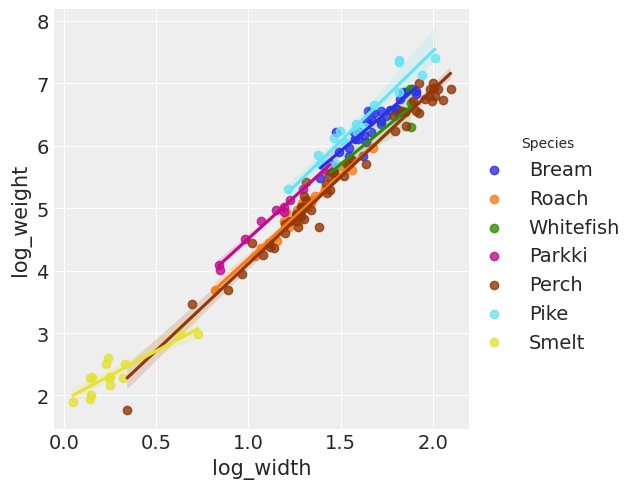

In [4]:
sns.lmplot(data=fish_reduced, x="log_width", y="log_weight", hue="Species",);

Let's load in the fish data from the linear regression module and plot them again. This time, however, I'm plotting all fish and their regression lines in the same plot.

Remember from before that Alex first built a model that fit a single regression to all fish species and found that it's not a good fit. He then fit separate regressions, like we're doing in this plot, which produced a much better fit.

But looking at the data, what do you think of that choice? Notice anything?

Yes, exactly, while the fish species aren't identical, they are pretty damn similar. I wonder why Alex did not notice that, I really worry about this guy sometimes. But don't worry, you're in good hands now.

# Two Lame Options

1. Pooled: Everything is exactly the same
2. Unpooled: Everything is different and shares no similarities

We can clearly see that neither of these are true in this data.

<img width=25% src="https://i.chzbgr.com/full/3897100288/h7F589938/stuck-between-a-rock-and-a-hard-place"/>

So to summarize, either we build a pooled model and assume all fish species are exactly the same, or we build an unpooled model that assumes they share no similarity at all.
Just like this sheep, it seems we are stuck between a rock and a hard place.

But feat not, for our dear Reverend Thomas Bayes comes to bust us out of this pickle once again.

<img src="https://miro.medium.com/max/920/1*_i4uVp43apgOMpHRw6WG-w.jpeg">

# Inception! Distributions **Over Parameters**

OK, welcome back! In this section we will get a better understanding of what the similarities look like in terms of the actual parameters. To do that, let's run the unpooled model from the previous section. Note, that to make the code simpler, we will now only consider a single predictor, rather than all three. The predictor we will use is the width.

In [5]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

species_idx, species = fish_train.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect"], #, "height_effect", "length_effect"],
    "species": species,
}

COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object')}

In [24]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("species"))

    # linear regression
    mu = pm.Deterministic("mu", intercept[species_idx_] + β[species_idx_] * log_width)
    
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled = pm.sample()
    idata_unpooled.extend(pm.sample_prior_predictive())
    idata_unpooled.extend(pm.sample_posterior_predictive(idata_unpooled))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


This is basically the same model you've seen in the last section, so I'm not going to go over it again.

Rather, let's look at the different intercept and beta parameters.

# Extract Posterior Means

In [25]:
df_plot = (idata_unpooled
           .posterior[["intercept", "β"]]
           .mean(("chain", "draw"))
           .to_dataframe()
           .rename_axis(columns="parameters")
           .stack()
           .reset_index()
           .rename(columns={0: "mean"})
          )
df_plot

species parameters      mean
0       Bream  intercept  2.412584
1       Bream          β  2.342613
2      Parkki  intercept  2.418754
3      Parkki          β  2.146039
4       Perch  intercept  1.342585
5       Perch          β  2.775624
6        Pike  intercept  2.218909
7        Pike          β  2.584988
8       Roach  intercept  1.922721
9       Roach          β  2.362836
10      Smelt  intercept  1.979447
11      Smelt          β  1.306918
12  Whitefish  intercept  2.718367
13  Whitefish          β  2.026981

To do so, we'll first extract the mean of the intercepts and betas and convert it to a `pandas.DataFrame`. There is some additional reformatting going on here to make plotting with seaborn easier.

But focus on the values, what do you see here? 

Maybe let's look at some histograms to get an even better feel for this.

# Histogram Over Intercepts And Slopes

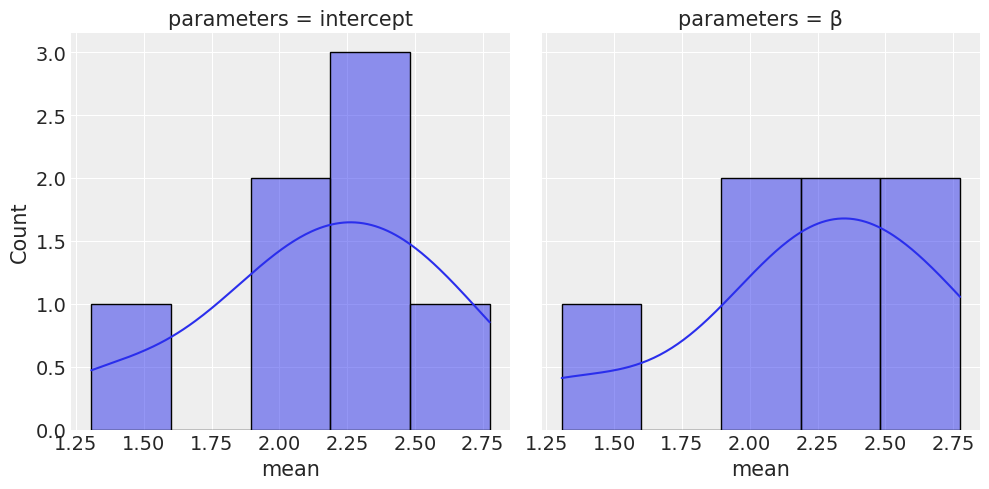

In [26]:
sns.displot(df_plot, x="mean", col="parameters", kde=True);

I know it's just a couple of points, but what does that look like to you?

Well the first thing to note is that the values are clustered around a common value, they are very similar like we already saw from looking at the data.

So how would you describe this data? Right, exactly, with a distribution. And the kernel density estimate makes it look like it could be a Normal distribution.

# Inception! Distributions over Parameters
<img src="https://memegenerator.net/img/instances/86091597.jpg"/>

* Old: specify a distribution over data points 
* New: specify a distribution over **a group of parameters**.

OK, so here is the central concept. Just like we can say that a set of data points is, for example, normally distributed, we can do the same for a group of parameters, in this case, the intercepts and slopes of the different fish.

I simultanesouly hope I just blew your mind because this is an insight with far-reaching consequences, but also hope I didn't because it's actually obvious we can do this.

In the next section we will see how we can express this idea in PyMC.

# Hierarchical Models In PyMC

In [40]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical:
    # data
    log_width = pm.ConstantData("log_width", fish_train.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

In [41]:
with fish_hierarchical:
    # hierarchy on intercepts
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=3.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", 
                                          sigma=1.0)
    # individual intercepts for each species
    intercept = pm.Normal("intercept", 
                          mu=group_intercept_mu,
                          sigma=group_intercept_sigma, 
                          dims="species")

In [42]:
with fish_hierarchical:
    # hierarchy on betas
    group_β_mu = pm.Normal("group_β_mu", sigma=3.0)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=1.0)
    # individual betas for each species
    β = pm.Normal("β", 
                  mu=group_β_mu, 
                  sigma=group_β_sigma, 
                  dims=("species"))

In [43]:
with fish_hierarchical:
    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width

In [44]:
with fish_hierarchical:
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)
    
    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

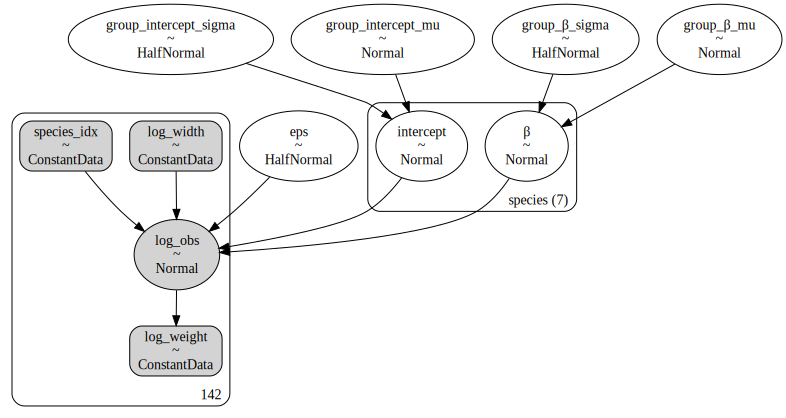

In [45]:
pm.model_to_graphviz(fish_hierarchical)

In [46]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample()
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


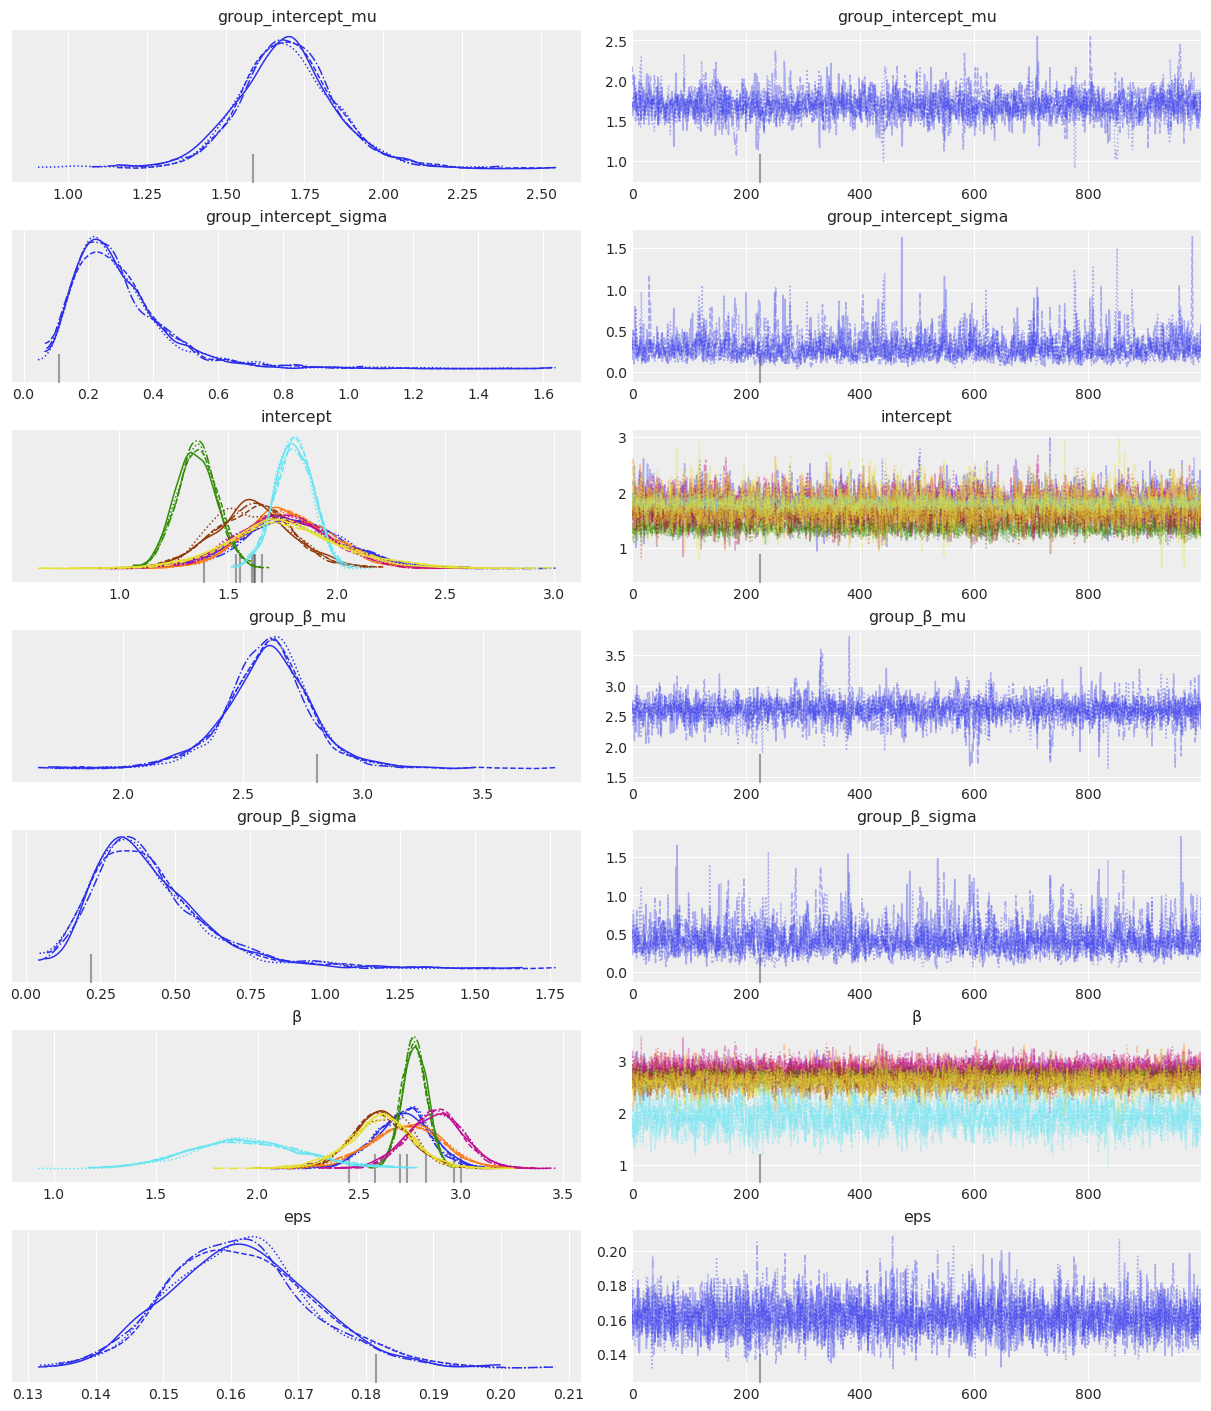

In [47]:
az.plot_trace(idata_hierarchical);

# Increasing `target_accept` to Get Rid of Divergences

In [48]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample(target_accept=0.99)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


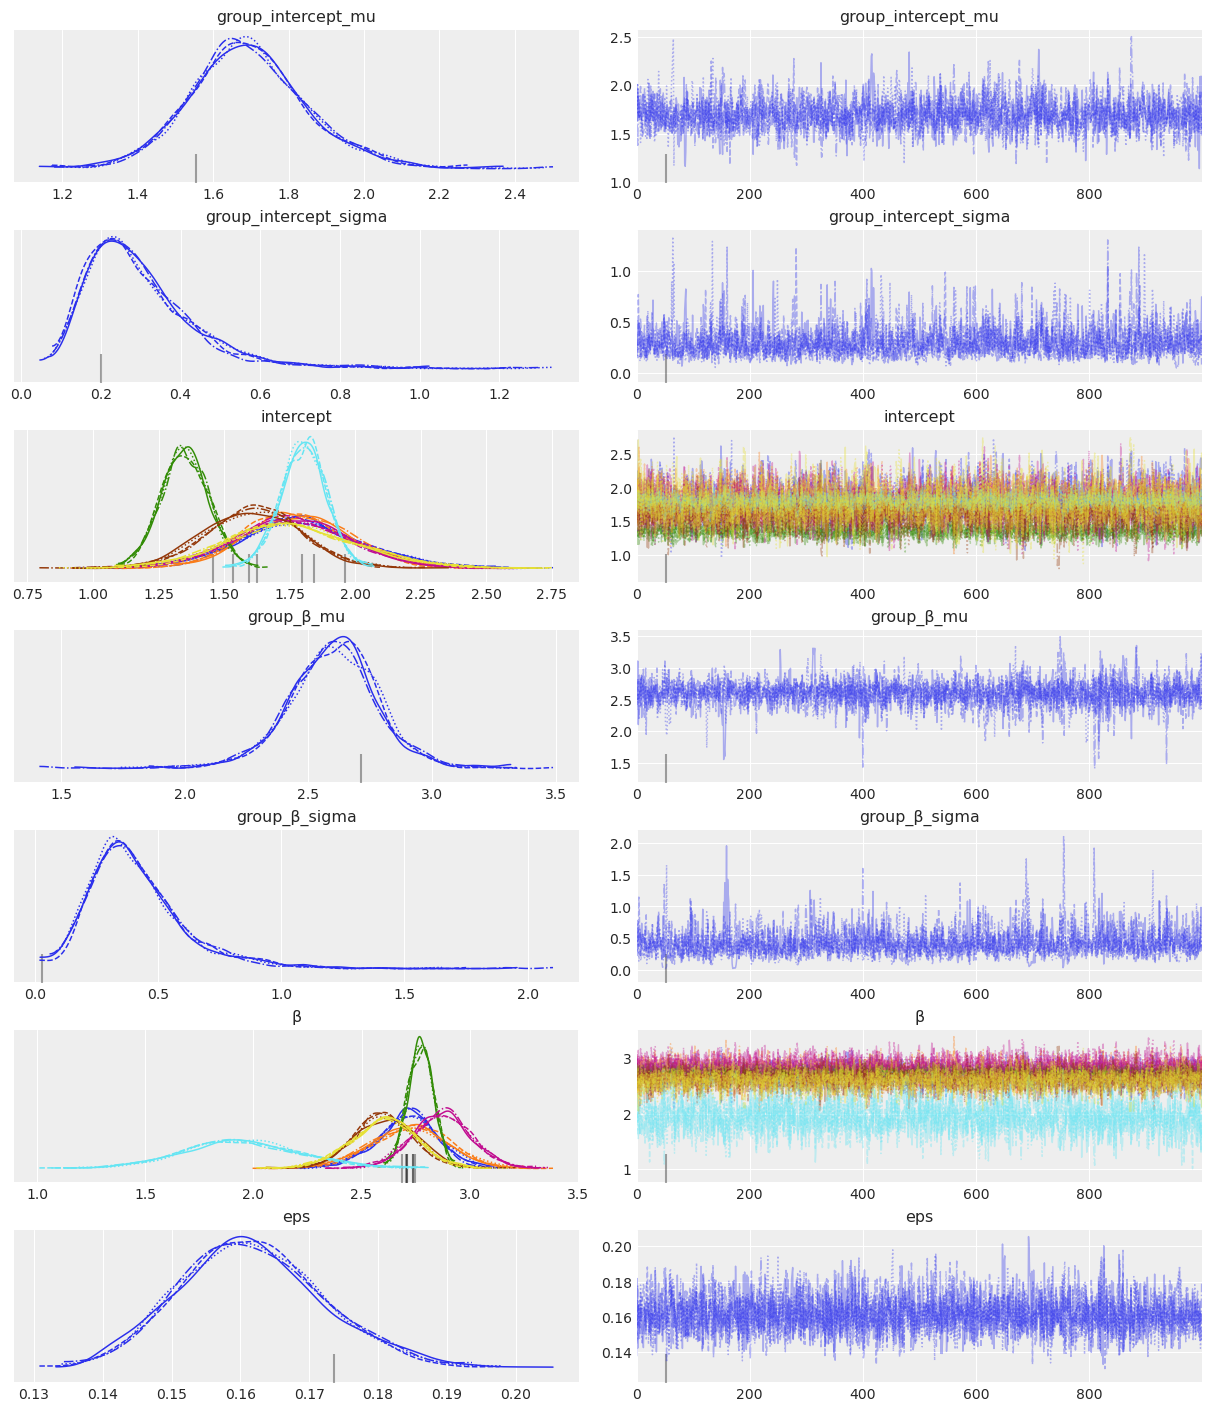

In [18]:
az.plot_trace(idata_hierarchical);

## Section Summary

* Instead of `pm.Normal("x", 0, 1, dims="d")` -> `pm.Normal("x", mu, sigma, dims="d")`
* Increase `target_accept` to get rid of divergences

# What Does the Hierarchy Actually Do?

* Effects on regression lines
* Effects on uncertainty
* Effects on mean estimate
* "Smart priors"

In this section we will take a look at what introducing the hierarchy into our model actually *does*. We will look at through different lenses. First, we'll look at the effect on the regression lines, then on the uncertainty, and on the mean.

This builds up our intutions around why hierarchies are so cool and in which cases they help especially well. We will also see a way to think about hierarchies as smart priors.

In [19]:
def plot_pred(idata, species="Whitefish", color="0.5", label="", ax=None):
    fish_spec = fish_reduced[fish_reduced.Species == species]
    x_lower = fish_spec["log_width"].min() - .5
    x_upper = fish_spec["log_width"].max() + .5
    x = np.linspace(x_lower, x_upper, 150)
    
    ys = []
    if ax is None:
        fig, ax = plt.subplots()
        ax.scatter(fish_spec["log_width"], fish_spec["log_weight"], color="k")
        
    y = idata.posterior["intercept"].sel(species=species).mean(("chain", "draw")).data + (x * idata.posterior["β"].sel(species=species).mean(("chain", "draw")).data)
    ax.plot(x, y, color=color, alpha=.8, lw=3, label=label)
    
    for count, i in enumerate(range(100, 150)):
        y = idata.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (x * idata.posterior["β"].sel(species=species, chain=0, draw=i).data)
        ys.append(y)
        ax.plot(x, y, color=color, alpha=.1)
        
    ax.set(xlabel="log_width", ylabel="log_weight", 
           title=f"Regression lines for {species}")
    
    if label != "":
        ax.legend()
        
    return ax

# How Much Data Do We Have for Every Species?

In [21]:
fish_reduced.groupby("Species").count()["Weight"].sort_values()

Species
Whitefish     6
Parkki       11
Smelt        14
Pike         17
Roach        19
Bream        35
Perch        56
Name: Weight, dtype: int64

First, let's note something about the data set we've been working with. As you can see from the counts, for some fish, like Perch, we have many measurements, while for others, like Whitefish we only have few data points.

Hierarchical models have a specific effect depending how much data we have per group, so in this section we will look at what the hierarchical model does to Whitefish and Perch.

# "Smart Priors"

* Unpooled: `β = pm.Normal("β", mu=0, sigma=1, dims=("species"))`
* Hierarchical: `β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, dims=("species"))`

Both provide *regularization*, one to `0`, the other to the **group mean**.
We **learn** the prior.

When in doubt, take the mean.

Let's look at this further to build our intuitions.

# Regression Lines Unpooled Model

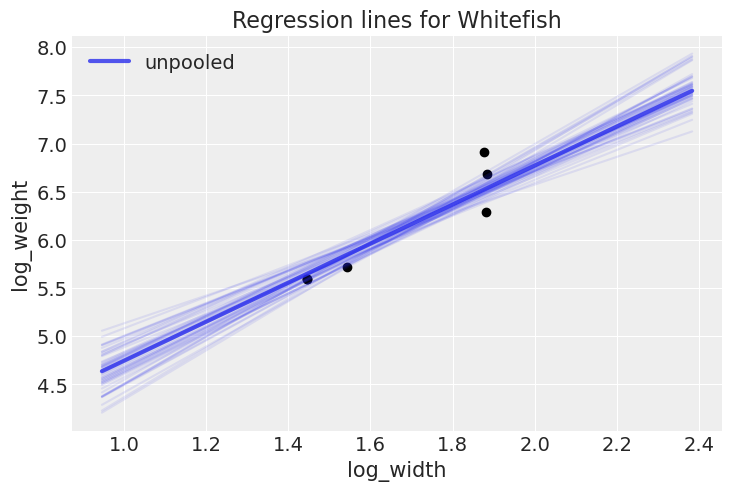

In [27]:
plot_pred(idata_unpooled, label="unpooled", color=sns.color_palette()[0]);

Here we see the regression lines for the unpooled model. The thick line is the mean while the lighter lines are individual draws from the posterior to give a sense of uncertainty. 

As you can see, we do not have a lot of data for Whitefish so our uncertainty is quite high: many regression lines could explain this data reasonably well.

Let's look at what happens in the hierarchical model.

# Regression Lines Unpooled Model

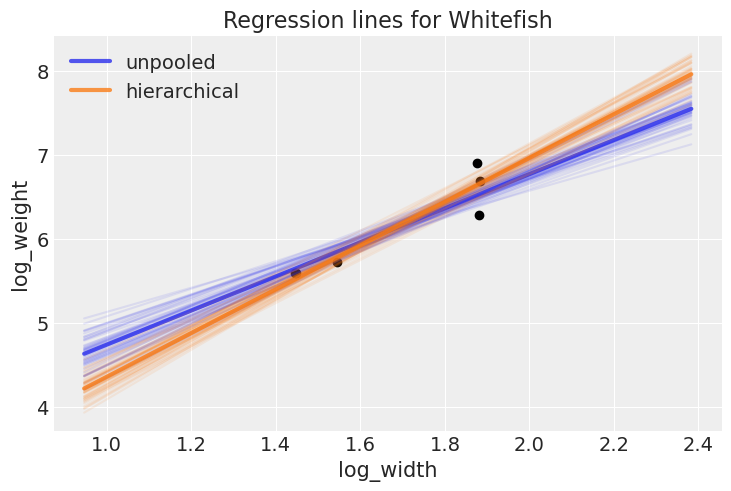

In [28]:
ax = plot_pred(idata_unpooled, label="unpooled", color=sns.color_palette()[0])
plot_pred(idata_hierarchical, label="hierarchical", color=sns.color_palette()[1], ax=ax);

Interesting, the line definitely changed. What are the two obvious changes?

Exactly, the location is different, but also the uncertainty is lower indicated by the lines being narrower around the mean.

Why is that happening? Let's look at the posteriors next to see what's going on.

# Posterior unpooled vs hierarchical

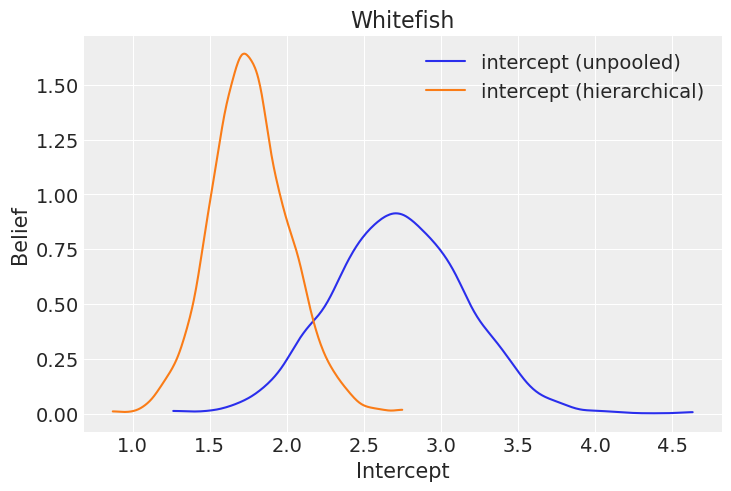

In [29]:
az.plot_dist(idata_unpooled.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[0], label="intercept (unpooled)")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[1], label="intercept (hierarchical)")
plt.xlabel("Intercept"); plt.ylabel("Belief"); plt.title("Whitefish");

Let's compare the posteriors between the two models. 

1. The intercept posterior of the unpooled model;
2. The intercept posterior of the hierarchical model.

What do you see?

One thing we notice is that indeed the uncertainty of the hierarchical intercept is lower than that of the unpooled model, which mirrors what we've seen on the previous plot. It's also estimated lower. But why is that the case? Where is that increased certainty and lower estimate coming from?

# Regularization Towards the Mean

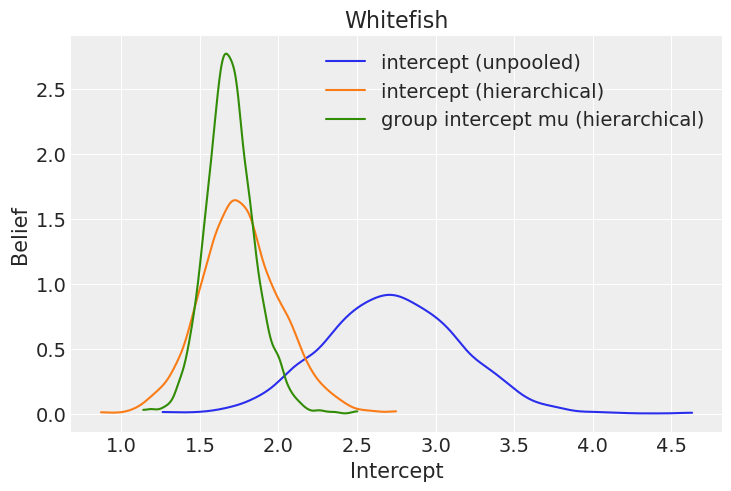

In [30]:
az.plot_dist(idata_unpooled.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[0], label="intercept (unpooled)")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Whitefish"), color=sns.color_palette()[1], label="intercept (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.group_intercept_mu, color=sns.color_palette()[2], label="group intercept mu (hierarchical)")
plt.xlabel("Intercept"); plt.ylabel("Belief"); plt.title("Whitefish");

Exactly! It's being pulled down by the mean, as you can see now that I add the group intercept mu parameter of the hierarchical model.

# Beta Posteriors

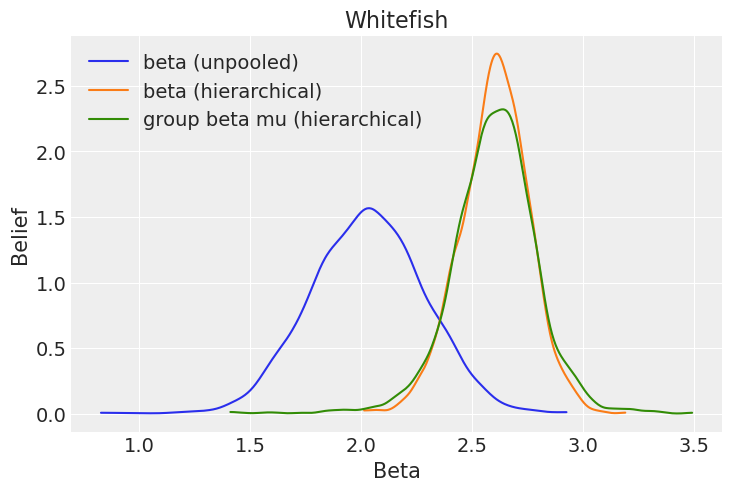

In [35]:
az.plot_dist(idata_unpooled.posterior.β.sel(species="Whitefish"), color=sns.color_palette()[0], label="beta (unpooled)")
az.plot_dist(idata_hierarchical.posterior.β.sel(species="Whitefish"), color=sns.color_palette()[1], label="beta (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.group_β_mu, color=sns.color_palette()[2], label="group beta mu (hierarchical)")
plt.xlabel("Beta"); plt.ylabel("Belief"); plt.title("Whitefish");

And looking at the beta posteriors we see the same pattern.

# Let's Look at Perch

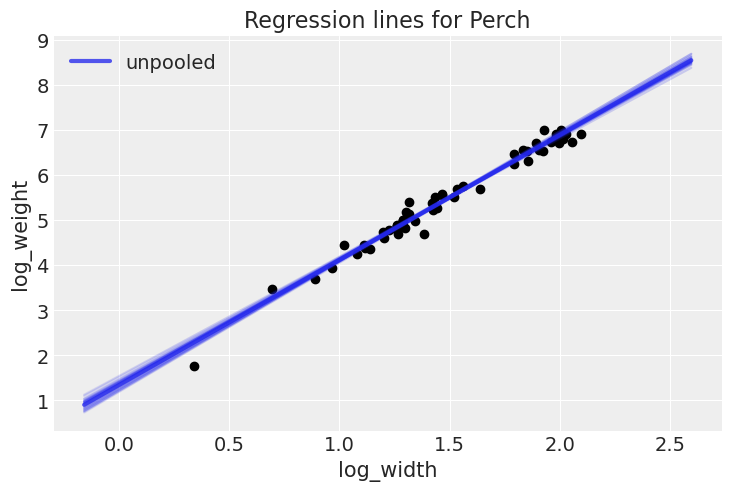

In [36]:
plot_pred(idata_unpooled, species="Perch", color=sns.color_palette()[0], label="unpooled");

OK, here we can see that there are many more data points and even the unpooled model is pretty certain about plausible regression lines.

Let's look at what the hierchical model says.

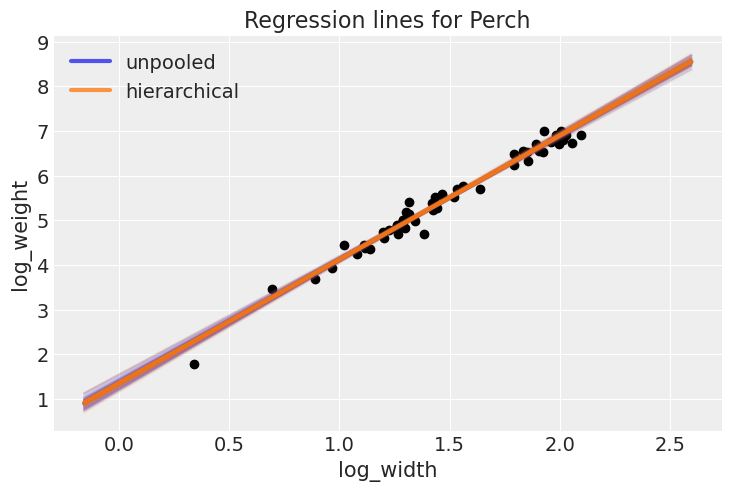

In [37]:
ax = plot_pred(idata_unpooled, species="Perch", color=sns.color_palette()[0], label="unpooled");
plot_pred(idata_hierarchical, species="Perch", color=sns.color_palette()[1], label="hierarchical", ax=ax);

Interersting, right? The two are almost identical. So it seems like the hierarchy does not have a big influence on the regression for Perch. Let's look next at the posteriors.

# And Now for the Posteriors...

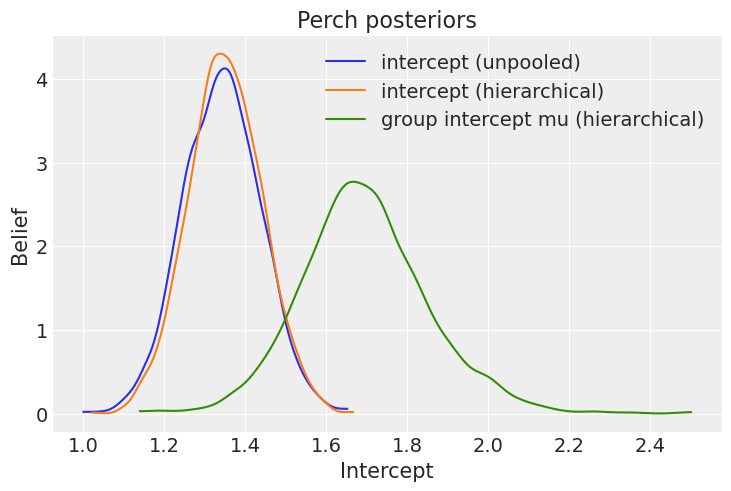

In [38]:
az.plot_dist(idata_unpooled.posterior.intercept.sel(species="Perch"), color=sns.color_palette()[0], label="intercept (unpooled)")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Perch"), color=sns.color_palette()[1], label="intercept (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.group_intercept_mu, color=sns.color_palette()[2], label="group intercept mu (hierarchical)")
plt.xlabel("Intercept"); plt.ylabel("Belief"); plt.title("Perch posteriors");

What do you see here? What's different compared to the posteriors for Whitefish?

Yes, the posteriors for the unpooled and hierarchical model are almost identical, the influence of the group intercept mu has almost no influence. 

# And for Beta...

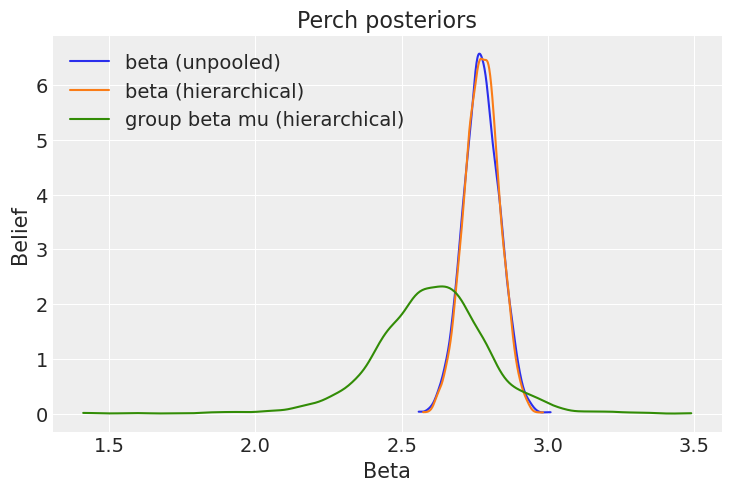

In [39]:
az.plot_dist(idata_unpooled_oos.posterior.β.sel(species="Perch"), color=sns.color_palette()[0], label="beta (unpooled)")
az.plot_dist(idata_hierarchical.posterior.β.sel(species="Perch"), color=sns.color_palette()[1], label="beta (hierarchical)")
az.plot_dist(idata_hierarchical.posterior.group_β_mu, color=sns.color_palette()[2], label="group beta mu (hierarchical)")
plt.xlabel("Beta"); plt.ylabel("Belief"); plt.title("Perch posteriors");

Looking at the posteriors for beta we see the same pattern.

# Conclusions

* Shrinkage towards the mean
* Group estimate <-> individual estimates
* Few data points -> strong shrinkage
* Many data points -> weak shrinkage
* -> Smart regularization

So to summarize, in this section we looked at what effect the hierarchy has on the model estimates, compared to the unpooled model that shares no information between different fish. What the hierarchy does is estimate a mean and standard-deviation of how the  intercepts and betas of the different fish species are distributed. These resulting "smart priors" that are learned from data then have a regularizing effect on the individual estimates: just like regular priors they provide shrinkage, in this case they shrink towards the group mean. 

So you can see how the constrain each other: the individual betas are used to estimate the group parameters, while the group parameters are used to constrain the individual betas. And our Bayesian framework is smart enough to figure out exactly the ideal interplay between them.

But you've also seen that this shrinkage towards the mean does not happen statically. In the case of few data points like for Whitefish we saw a strong shrinkage effect, while in the case where we had many data points like for Perch the group distribution had almost no effect. That's why I called this here "smart regularization".

It is worth noting that nothing magical is going on here either. As I mentioned before, we can think of the hierarchy as "smart priors". And just like with regular priors, the prior is easily overwhelmed by data, and in the case of Perch we have enough data to overwhelm our "smart prior".

# The Power of Bayes

* Hierarchical models great example of the benefits

OK, in this last section I want to perform the final step of our inception. This hierarchical linear regression is really cool, right? I hope while going through this you already had ideas of where you can apply this to your own problems.

However, we are not constrained to just this particular pattern. We can place hierarchies in all kinds of models, not just regressions. If you run multiple AB tests for example, you can put those into a hierarchy.

# Hierarchical Time-Series
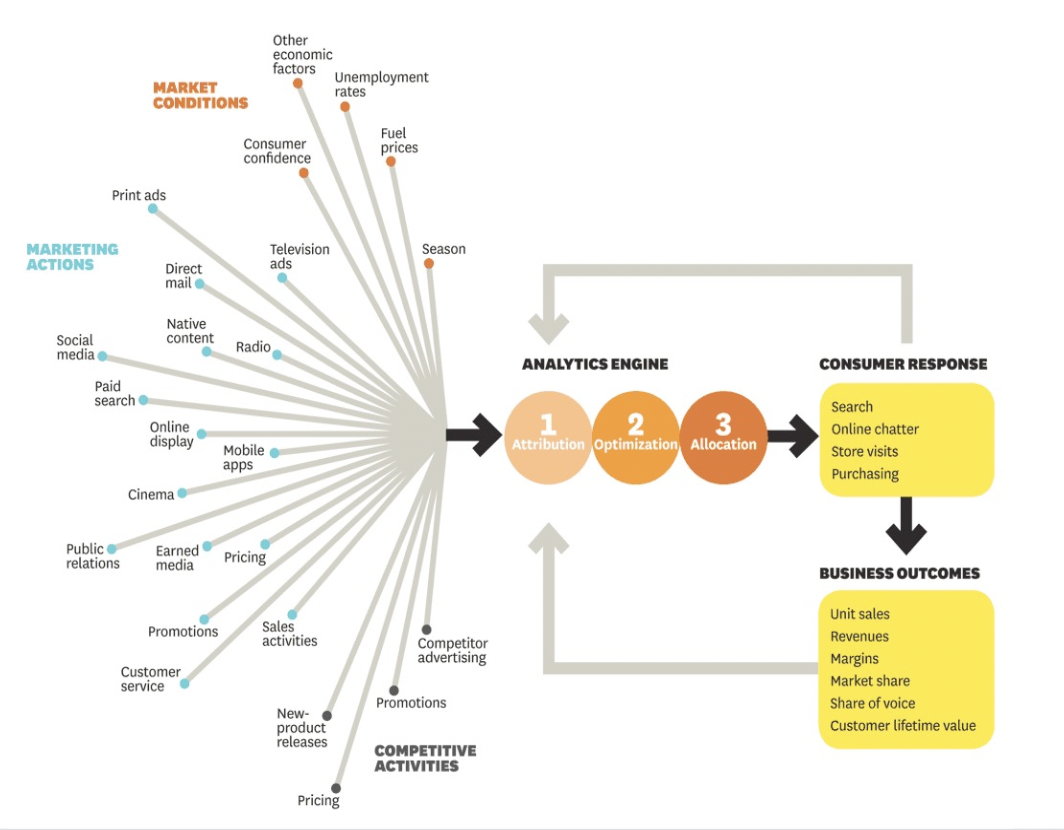

Or coming back to Bayesian Media Mix Model I showed you briefly at the very beginning. Different marketing channels like Google Ads and Facebook Ads are actually changing over time, so in our work with HelloFresh we placed a time-varying distribution on them. But they all ad channels also share similarity in *how* they change over time. So we place a hierarchical time-varying group-distribution over the different ad channels.

# Plugging Parameters Into Parameters

<table><tr>
<td><img width=100% src="https://parenthesis-info.org/wp-content/uploads/2019/05/Traditional_Russian_Matryoshka.jpg"></td>
<td><img width=100% src="https://1.bp.blogspot.com/-wiuOhBdx6Ug/V0IpKOUiSpI/AAAAAAAAfYc/fnXs_qvt64sRAZTqdoRFL294Q8Q86XtogCLcB/s1600/russian-doll-train-ticket.jpg"/></td>
    </tr>
</table>
    

But hierarchies are just one pattern. Really the key insight is that we can input parameters into other parameters and build insanely complex models this way. This Russian doll approach also plays a big role when we think about generative modeling.

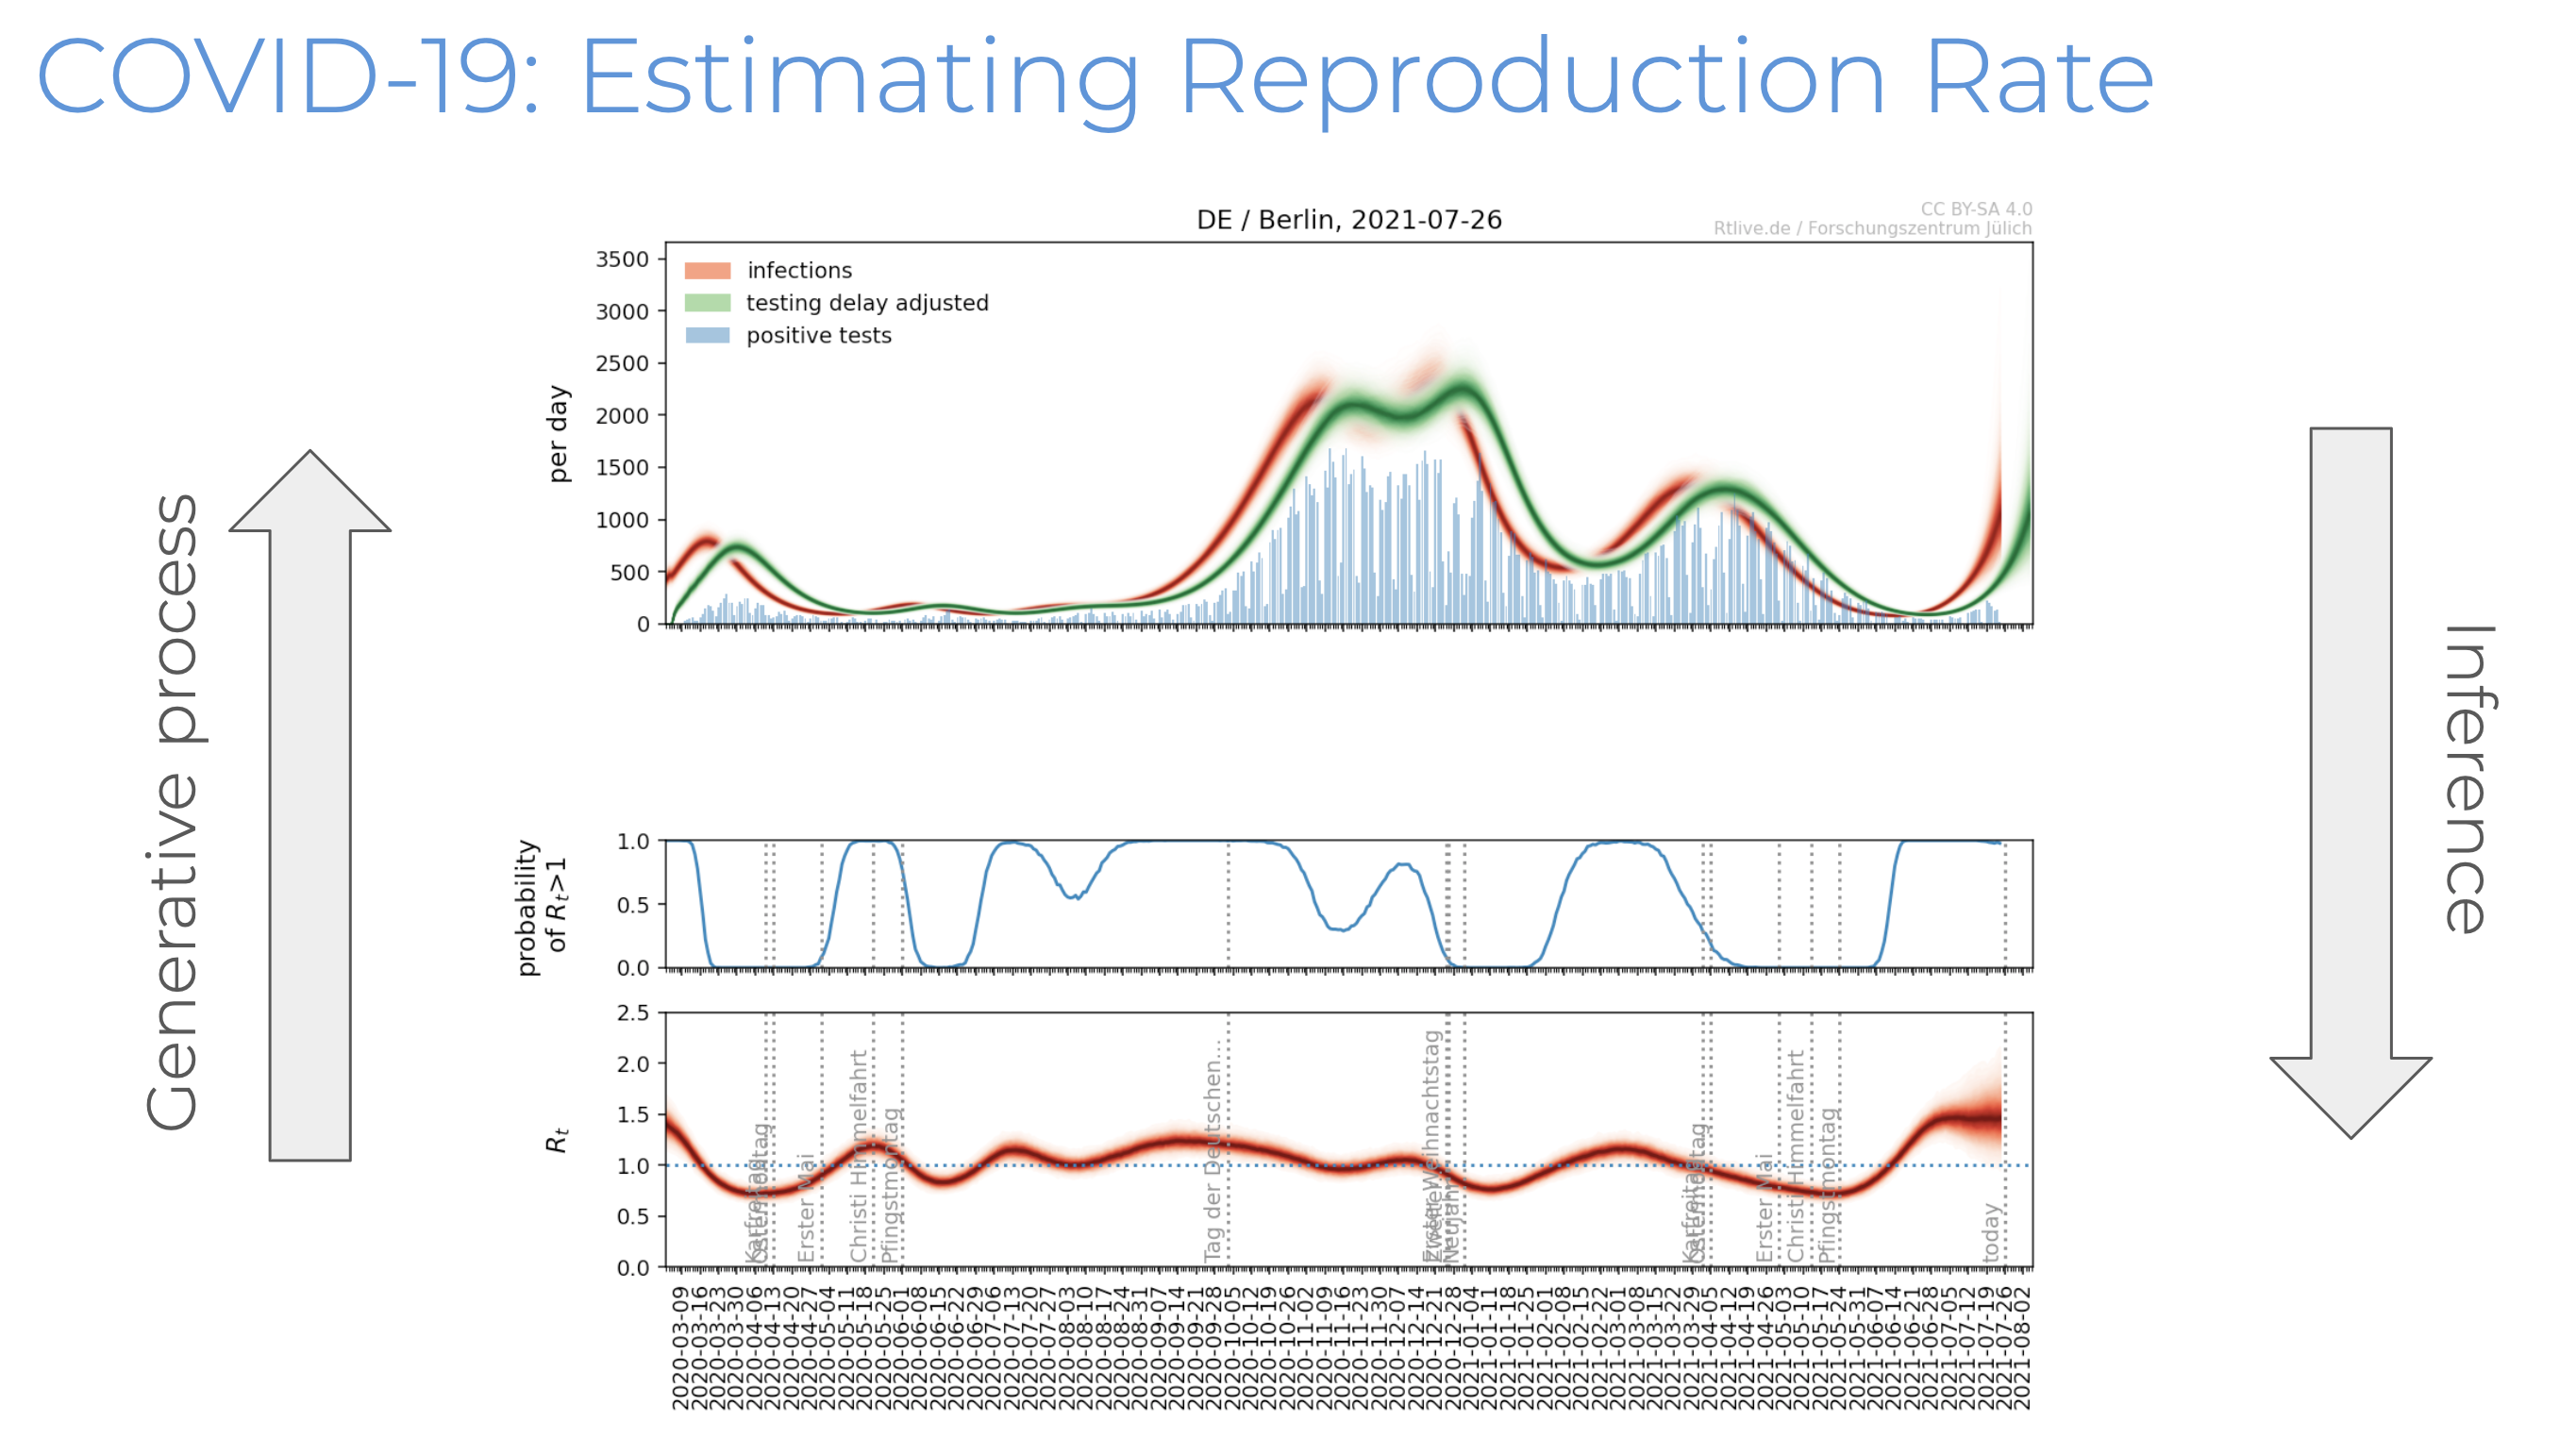

Remember this slide from the introduction? There we made heavy use of this principle of plugging parameters into other parameters to model the generative process. One person was infecting a certain number of other people, then these have an incubation period, as well as a period where they develop symptoms, and then finally get a test that then shows up in our data set. At every step we chain parameters into parameters.

# Section Summary

* Hierarchies can be used widely
* Plugging parameters into other parameters adds lots of flexibility

# Lesson Summary

* Pooled and unpooled models unsatisfactory
* Species parameters are distributed normally
* -> Place normal distribution on species parameters
* Acts as "smart prior" that is learned from data
* Provides smart regularization based on number of data points
* Stacking parameters allows for great model flexibility

Alright, so to summarize this lesson, we started by seeing how being forced to treat specy parameters as either being identical, like in a pooled model, or completely separate, like in an unpooled model is unsatisfactory.

We then looked at how the intercepts and betas of the different species were distributed and saw that they can be described via a normal distribution. In PyMC this is quite easy to implement.

I then showed you what the hierarchy actually adds to our inference. By thinking about them like a smart prior that gets learned from the data, we saw that if you have few data points, you get a lot of regularization, while if you have many data points, the group distribution has little influence on our species estimate. This is what I call *smart regularization* here.

Finally, I showed you how this idea of stacking parameters over other parameters is a very powerful idea that allows us to build all kinds of complicated models that accuratey map a business problem to a statistical model.

# Backup

In [ ]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical_nc:
    # data
    log_width = pm.Data("log_width", fish_train.log_width.values)
    log_height = pm.Data("log_height", fish_train.log_height.values)
    log_length = pm.Data("log_length", fish_train.log_length.values)
    log_weight = pm.Data("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=5.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=.1)
    intercept = pm.Normal("intercept", dims="species") * group_intercept_sigma + group_intercept_mu
    
    group_β_mu = pm.Normal("group_β_mu", sigma=3.5)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.05)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, dims=("species", "slopes")) #*  + group_β_mu

    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * log_width
        + β[species_idx_, 1] * log_height
        + β[species_idx_, 2] * log_length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample(init="jitter+adapt_diag", tune=1000, target_accept=0.9)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

In [ ]:
with fish_unpooled_oos:
    # update values of predictors:
    pm.set_data(
        {
            "log_height": fish_test.log_height.values,
            "log_length": fish_test.log_length.values,
            "log_width": fish_test.log_width.values,
            "species_idx": fish_test.Species.factorize(sort=True)[0],
        }
    )

Once that's done, we can just call `sample_posterior_predictive`. The only difference is that we're telling PyMC these are really predictions (`predictions=True`), and we want them appended to our existing `InferenceData` object (`extend_inferencedata=True`).

In [ ]:
with fish_unpooled_oos:
    # use the updated values to predict outcomes:
    idata_unpooled_oos = pm.sample_posterior_predictive(
        idata_unpooled_oos,
        predictions=True,
        extend_inferencedata=True,  # not released yet, needs main branch
    )

In [ ]:
az.plot_posterior(
    idata_unpooled_oos.predictions,
    ref_val=fish_test["Weight"].tolist(),
    transform=np.exp,
);

### Section recap

- Use `pm.set_data` to update the values of predictors
- `pm.sample_posterior_predictive(predictions=True, extend_inferencedata=True)` uses the updated values to predict outcomes and appends them to the original `InferenceData` object
- `az.plot_posterior` is an easy and concise way to check the quality of and uncertainty in those predictions